# Face Landmarks

Using a subset of [UMD Faces](http://umdfaces.io) database to train a face landmarks predicting model.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
from multiprocessing import Pool
from os.path import join
from pathlib import Path
from copy import deepcopy
import random
import math
import sys

In [3]:
try:
    old_path
except NameError:
    old_path = sys.path
    new_path = [str(Path.cwd()/'loop')] + old_path
    sys.path = new_path

In [72]:
import pandas as pd
import numpy as np
import cv2 as cv
import PIL.Image
from imageio import imread
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.ticker as mtick
from pandas_summary import DataFrameSummary
from tqdm import tqdm_notebook as tqdm

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import models
from torchvision.transforms.functional import to_tensor, normalize

In [5]:
import loop
from loop import callbacks as C
from loop.config import defaults
from loop.optimizers import AdamW
from loop.torch_helpers.modules import Flatten
from loop.training import make_phases, find_lr
from loop.torch_helpers.modules import Classifier
from loop.schedule import OneCycleSchedule, CosineAnnealingSchedule
from basedir import DATA, META, CROPPED, NUM_LANDMARKS

/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
SEED = 1
DEVICE = torch.device('cuda:1')
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
defaults.device = DEVICE

---
## Dataset First Glance

In [7]:
meta = pd.read_csv(META)
meta.columns = meta.columns.str.lower()
cols = meta.columns
file_cols = ['subject_id', 'file']
face_cols = cols[cols.str.startswith('face')].tolist()
x_cols = cols[cols.str.startswith('p') & cols.str.endswith('x')].tolist()
y_cols = cols[cols.str.startswith('p') & cols.str.endswith('y')].tolist()
faces_df = meta[file_cols + face_cols + x_cols + y_cols]
faces_df.head()

,subject_id,file,face_x,face_y,face_width,face_height,p1x,p2x,p3x,p4x,...,p12y,p13y,p14y,p15y,p16y,p17y,p18y,p19y,p20y,p21y
0,1,andrew_j_feustel/andrew_j_feustel_0001.jpg,396.10470,115.99280,55.28760,53.28240,406.4610,411.5070,417.1110,428.6170,...,127.0370,140.5620,138.0710,138.8910,138.602,142.3300,147.6620,149.1460,148.159,164.835
1,1,andrew_j_feustel/andrew_j_feustel_0002.jpg,808.97000,218.05190,51.22800,49.00920,814.2580,818.2730,823.3880,834.2550,...,227.0650,245.2970,239.5190,238.9180,238.428,240.4170,248.7770,248.6390,246.979,262.977
2,1,andrew_j_feustel/andrew_j_feustel_0003.jpg,116.16960,82.37583,54.30480,56.21364,120.6950,122.2240,125.1790,132.0140,...,94.0531,110.1360,109.3490,106.9300,108.483,111.0730,119.6780,118.6960,118.978,133.905
3,1,andrew_j_feustel/andrew_j_feustel_0004.jpg,483.74100,213.87210,320.85600,313.16280,552.0410,587.0870,625.0260,693.3090,...,273.0160,350.0050,345.9300,352.6960,347.401,353.7210,402.4170,410.8210,402.350,500.938
4,1,andrew_j_feustel/andrew_j_feustel_0005.jpg,19.08284,52.63863,65.63352,64.68804,30.0739,36.4028,43.5955,58.0033,...,65.4809,83.2004,79.2413,80.0437,79.606,84.1834,91.0663,92.6855,91.236,111.936


In [76]:
dfs = DataFrameSummary(faces_df)
dfs.columns_stats.T

,counts,uniques,missing,missing_perc,types
subject_id,77228,2133,0,0%,numeric
file,77228,77228,0,0%,unique
face_x,77228,72778,0,0%,numeric
face_y,77228,72636,0,0%,numeric
face_width,77228,67760,0,0%,numeric
face_height,77228,69458,0,0%,numeric
p1x,77228,69073,0,0%,numeric
p2x,77228,69015,0,0%,numeric
p3x,77228,68781,0,0%,numeric
p4x,77228,68704,0,0%,numeric


In [8]:
def show(i, ax=None):
    global faces_df, DATA
    r = faces_df.loc[i]
    img = imread(DATA/r.file)
    x_pts = [r[k] for k in r.keys() if k[0] == 'p' and k[-1] == 'x']
    y_pts = [r[k] for k in r.keys() if k[0] == 'p' and k[-1] == 'y']
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(8, 8))
    rc = Rectangle(xy=(r.face_x, r.face_y), 
                   width=r.face_width, height=r.face_height,
                   edgecolor='red', fill=False, lw=5)
    ax.imshow(img)
    ax.scatter(x_pts, y_pts, edgecolor='white', color='lightgreen', alpha=0.8)    
    ax.add_patch(rc)

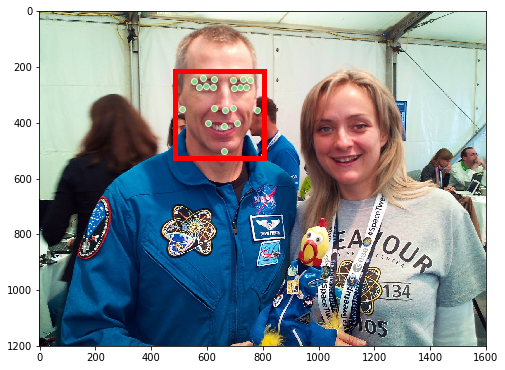

In [9]:
show(3)

In [10]:
def show_grid(n=3, figsize=(10, 10)):
    global faces_df
    f, axes = plt.subplots(n, n, figsize=figsize)
    indicies = np.random.choice(len(faces_df), n ** 2, replace=False)
    for i, ax in zip(indicies, axes.flat):
        show(i, ax=ax)
        ax.set_axis_off()

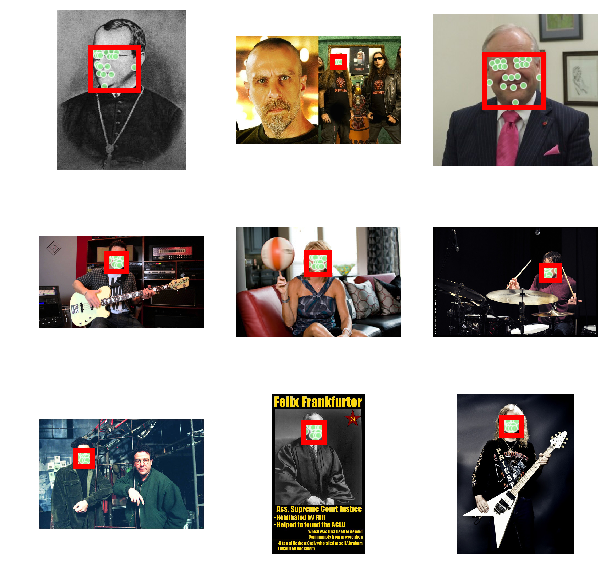

In [11]:
show_grid()

Ok, it seems that each sample includes (at least) one human in various poses with various backgrounds. Therefore, our first goal is to convert this dataset into a more suitable format before we processed with training the model. The most straightforward way to do so is to _crop_ the faces only and save them into smaller files.

---

In [12]:
def split(target):
    return target[:NUM_LANDMARKS//2], target[NUM_LANDMARKS//2:]

In [13]:
def create_dataset_item(info, root):
    """Creates a dictionary with face and landmarks coordinates from data frame record."""
    
    return {
        'subject_id': info.subject_id,
        'image_path': str(root/info.file),
        'x_pos': [info[k] for k in info.keys() if k[0] == 'p' and k[-1] == 'x'],
        'y_pos': [info[k] for k in info.keys() if k[0] == 'p' and k[-1] == 'y'],
        'face': (info.face_x, info.face_y, info.face_width, info.face_height)}

In [14]:
items = [create_dataset_item(record, DATA) for _, record in meta.iterrows()]

In [15]:
trn_idx, val_idx = train_test_split(np.arange(len(items)), test_size=0.1, random_state=SEED)

In [16]:
train = np.array(items)[trn_idx].tolist()
valid = np.array(items)[val_idx].tolist()

In [17]:
class FaceLandmarks:
    
    def __init__(self, items, transforms=None, to_tensors=None):
        self.items = items
        self.transforms = transforms
        self.to_tensors = to_tensors
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, item):
        return self._transform(*self.get(item))
    
    def show(self, item, ax=None, **fig_kwargs):
        self._show(*self.get(item), **fig_kwargs)

    def show_transformed(self, item, ax=None, **fig_kwargs):
        self._show(*self._transform(*self.get(item), as_tensors=False))
        
    def get(self, item):
        record = self.items[item]
        img = imread(record['image_path'])
        pts = np.array(record['x_pos'] + record['y_pos'], dtype='float32')
        return img, pts
    
    def _show(self, img, pts, ax=None, **fig_kwargs):
        if ax is None:
            f, ax = plt.subplots(1, 1, **fig_kwargs)
        ax.imshow(img.astype(np.uint8))
        ax.scatter(*split(pts), color='lightgreen', edgecolor='white', alpha=0.8)
        ax.set_axis_off()
    
    def _transform(self, img, pts, as_tensors=True):
        if self.transforms:
            for transform in self.transforms:
                img, pts = transform(img, pts)
        if as_tensors and self.to_tensors is not None:
            img, pts = self.to_tensors(img, pts)
        return img, pts

In [18]:
ds = FaceLandmarks(train)

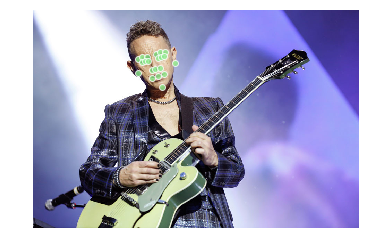

In [19]:
ds.show(3)

---

In [20]:
def binomial(p):
    return np.random.rand() <= p

In [21]:
def rotation_matrix(x, y=None, angle=5):
    h, w = x.shape[:2]
    minmax = (-angle, angle) if isinstance(angle, int) else angle
    a = np.random.uniform(*minmax)
    m = cv.getRotationMatrix2D((w/2, h/2), a, 1)
    m = np.r_[m, [[0, 0, 1]]]
    return m

In [22]:
def shift_matrix(x, y=None, shift=0.01):
    h, w = x.shape[:2]
    sx, sy = (shift, shift) if isinstance(shift, float) else shift
    shift_x = np.random.randint(-w*sx, w*sx)
    shift_y = np.random.randint(-h*sy, h*sy)
    m = np.float32([
        [1, 0, shift_x],
        [0, 1, shift_y],
        [0, 0, 1]]) 
    return m

In [23]:
def mirror_matrix(x, y=None, horizontal=True):
    h, w = x.shape[:2]
    c1, c2 = (-1, 1) if horizontal else (1, -1)
    s1, s2 = (w, 0) if horizontal else (0, h)
    return np.float32([[c1, 0, s1], [0, c2, s2], [0, 0, 1]])

In [24]:
def perspective_matrix(x, y=None, percentage=(0.05, 0.12)):
    h, w = x.shape[:2]
    
    def rx(): 
        return int(w*np.random.uniform(*percentage))
    
    def ry(): 
        return int(h*np.random.uniform(*percentage))
    
    tl = [0   + rx(), 0   + ry()]
    tr = [w-1 - rx(), 0   + ry()]
    br = [w-1 - rx(), h-1 - ry()]
    bl = [0   + rx(), h-1 - ry()]
    src = np.float32([tl, tr, br, bl])
    dst = np.float32([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]])
    m = cv.getPerspectiveTransform(src, dst)
    return m

In [25]:
class MatrixAugmentation:
    def __init__(self, conf, default_prob=0.5):
        augmentations = {
            'rotation': rotation_matrix,
            'shift': shift_matrix,
            'mirror': mirror_matrix,
            'perspective': perspective_matrix}
        
        pipe = []
        for params in deepcopy(conf):
            name = params.pop('name')
            func = augmentations.get(name)
            if func is None:
                raise ValueError(f'unknown augmentation function: {name}')
            p = params.pop('p', default_prob)
            pipe.append((p, func, params))

        self.pipe = pipe
        
    def __call__(self, image, target=None):
        h, w = image.shape[:2]
        
        m = np.eye(3)
        for p, func, params in self.pipe:
            if binomial(p):
                m = func(image, target, **params) @ m
        
        aug_image = cv.warpPerspective(image, m, (w, h))
        if target is not None:
            new = target.copy()
            n = len(target)//2
            for i in range(n):
                x, y = target[i], target[i + n]
                denom = m[2][0]*x + m[2][1]*y + m[2][2]
                new[i] = (m[0][0]*x + m[0][1]*y + m[0][2])/denom
                new[i + n] = (m[1][0]*x + m[1][1]*y + m[1][2])/denom
            target = new
            
        return aug_image, target

In [26]:
class CropResizeFace:
    def __init__(self, size=224, pad=0.05):
        self.size = size
        self.pad = pad
        self.failed = []
    
    def __call__(self, image, target):
        size = self.size
        xs, ys = split(target)
        x_min, x_max, y_min, y_max = xs.min(), xs.max(), ys.min(), ys.max()
        
        w, h = x_max - x_min, y_max - y_min
        x_pad = w*self.pad
        y_pad = h*self.pad
        
        x_min -= x_pad
        x_max += x_pad
        y_min -= y_pad
        y_max += y_pad
        
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(image.shape[1], x_max), min(image.shape[0], y_max), 
        
        cropped = image[int(y_min):int(y_max), int(x_min):int(x_max)]
        if 0 in cropped.shape:
            self.failed.append((image, target))
            cropped = image
        else:
            xs -= x_min
            ys -= y_min
        
        new_w, new_h = (size, size) if isinstance(size, int) else size
        old_h, old_w = cropped.shape[:2]
        cropped = cv.resize(cropped, (new_w, new_h))
        rx, ry = new_w/old_w, new_h/old_h
        xs *= rx
        ys *= ry
        return cropped, np.r_[xs, ys]

In [27]:
class AdjustGamma:
    def __init__(self, min_gamma=0.5, max_gamma=1.5):
        self.minmax = min_gamma, max_gamma
    
    def __call__(self, image, target=None):
        gamma = np.random.uniform(*self.minmax)
        inv_gamma = 1.0 / gamma
        table = np.array([
          ((i / 255.0) ** inv_gamma) * 255
          for i in np.arange(0, 256)])
        adjusted = cv.LUT(
            image.astype(np.uint8), 
            table.astype(np.uint8))
        return adjusted.astype(np.float32), target

In [28]:
ds.transforms = [
    MatrixAugmentation([
        {'name': 'rotation', 'angle': 10},
        {'name': 'mirror'},
        {'name': 'perspective', 'percentage': (0.075, 0.012)}
    ]),
    CropResizeFace(pad=0.15),
    AdjustGamma(min_gamma=0.7)
]

---

## Images Cropping

In [29]:
IMAGENET_STATS = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

In [30]:
def as_is(xs, ys, w, h):
    return xs, ys

In [31]:
def to_centered(xs, ys, w, h):
    return 2*xs/w - 1, 2*ys/h - 1

In [32]:
def to_absolute(xs, ys, w, h):
    return w*(xs + 1)/2., h*(ys + 1)/2. 

In [33]:
def to_np(t):
    return t.cpu().detach().contiguous().numpy()

In [34]:
class ToXY:
    """Converts image and landmarks into tensors of appropriate format.
    
    Includes inverse transformation to convert training and prediction tensors
    back into visualization-suitable format.
    """
    def __init__(self, stats=None, y_rescale=True):
        self.stats = stats
        self.y_rescale = y_rescale
        
    def __call__(self, image, points):
        return self.transform(image, points)
    
    def transform(self, image, points):
        if self.y_rescale:
            xs, ys = split(points)
            h, w = image.shape[:2]
            points = np.r_[to_centered(xs, ys, w, h)]
        t_img = to_tensor(image.astype(np.uint8))
        t_pts = torch.tensor(points, dtype=t_img.dtype)
        if self.stats is not None:
            t_img = normalize(t_img, *self.stats)
        return t_img, t_pts
    
    def inverse(self, t_image, t_points):
        np_img, np_pts = [to_np(t) for t in (t_image, t_points)]
        np_img = np_img.transpose(1, 2, 0)
        np_pts = np_pts.flatten()
        if self.y_rescale:
            h, w = np_img.shape[:2]
            xs, ys = to_absolute(*split(np_pts), w, h)
            np_pts = np.r_[xs, ys]
        if self.stats is not None:
            mean, std = self.stats
            np_img *= np.array(std)
            np_img += np.array(mean)
        np_img *= 255
        np_img = np_img.astype(np.uint8)
        return np_img, np_pts

In [35]:
# class WingLoss(nn.Module):
#     def __init__(self, w=10, eps=2):
#         super().__init__()
#         self.w = w
#         self.eps = eps
#         self.c = w - w*np.log(1 + w/eps)
        
#     def forward(self, x, y):
#         d = (x - y).abs()
#         lt, gt = d < self.w, d >= self.w
#         d[lt] = self.w*(1 + d[lt].div(self.eps)).log()
#         d[gt] = d[gt] - self.c
#         return d.mean()

In [61]:
epochs = 10
bs = 1024

trn_ds = FaceLandmarks(
    items=train, 
    transforms=[
        MatrixAugmentation([
            {'name': 'rotation', 'angle': 10},
            {'name': 'mirror'},
            {'name': 'perspective', 'percentage': (0.075, 0.012)}
        ]),
        CropResizeFace(pad=0.15),
        AdjustGamma(min_gamma=0.7)
    ], 
    to_tensors=ToXY(IMAGENET_STATS)
)

val_ds = FaceLandmarks(
    items=valid, 
    transforms=[CropResizeFace(pad=0.15)], 
    to_tensors=ToXY(IMAGENET_STATS))

phases = make_phases(trn_ds, val_ds, batch_size=bs, num_workers=12)
schedule = OneCycleSchedule(len(phases[0].loader) * epochs)
callbacks = C.CallbacksGroup([
    C.RollingLoss(),
    C.StreamLogger(),
    C.ProgressBar(),
    C.History(),
    C.Scheduler(schedule=schedule,
                mode='batch',
                params_conf=[{'name': 'lr'},
                             {'name': 'weight_decay', 'inverse': True}])
])
loss = F.l1_loss # WingLoss()

In [62]:
model = Classifier(NUM_LANDMARKS, arch=models.resnet34, top=[1024, 1024], activ=nn.Tanh())
model.freeze_backbone()

In [63]:
opt = AdamW(model.parameters(), lr=5e-3, weight_decay=1e-3)
loop.train(model, opt, phases, callbacks, epochs, defaults.device, loss)

Epoch:    1 | train_loss=0.5141, valid_loss=0.3302
Epoch:    2 | train_loss=0.3097, valid_loss=0.2537
Epoch:    3 | train_loss=0.2345, valid_loss=0.2296
Epoch:    4 | train_loss=0.2128, valid_loss=0.2157
Epoch:    5 | train_loss=0.2057, valid_loss=0.2068
Epoch:    6 | train_loss=0.2027, valid_loss=0.2031
Epoch:    7 | train_loss=0.2013, valid_loss=0.2017
Epoch:    8 | train_loss=0.1998, valid_loss=0.1988
Epoch:    9 | train_loss=0.1988, valid_loss=0.1997
Epoch:   10 | train_loss=0.1988, valid_loss=0.2009




In [ ]:
def plot_loss_curve(learning_rates, log_loss, zoom=None, ax=None, figsize=(10, 8)):
    lrs, losses = learning_rates, log_loss
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=figsize)
    if zoom is not None:
        min_lr, max_lr = zoom
        lrs, losses = zip(*[(x, y) for x, y in zip(lrs, losses) if min_lr <= x <= max_lr])
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%1.0e'))

In [ ]:
opt = AdamW(model.parameters(), lr=1e-3)
lrs, log_loss = find_lr(model, opt, trn_ds, batch_size=512, loss_fn=loss)
plot_loss_curve(lrs, log_loss)

In [ ]:
opt = AdamW(model.parameters(), lr=5e-02)
loop.train(model, opt, phases, callbacks, epochs, defaults.device, loss)

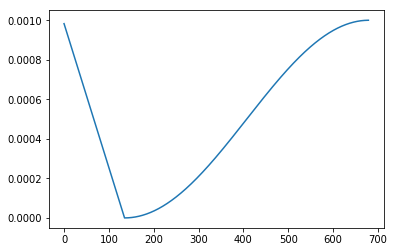

In [65]:
plt.plot(callbacks['scheduler'].parameter_history('weight_decay'))

In [ ]:
model = torch.load('best_epochs_8.model')

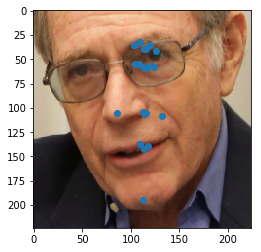

In [69]:
model.eval()
test_img, test_pts = val_ds[23]
pred = model(test_img[None].to(defaults.device))
np_img, np_pts = val_ds.to_tensors.inverse(test_img, pred)
plt.imshow(np_img)
plt.scatter(*split(np_pts))

In [ ]:
def conv(ni, no, kernel, stride, groups=1, lrn=False, bn=False, pool=None, activ='prelu'):
    layers = [nn.Conv2d(ni, no, kernel, stride, groups=groups)]
    activation = {
        'relu': nn.ReLU(inplace=True),
        'prelu': nn.PReLU(),
        'linear': None
    }[activ]
    if activation is not None:
        layers += [nn.PReLU()]
    if lrn:
        layers.append(nn.LocalResponseNorm(2))
    elif bn:
        layers.append(nn.BatchNorm2d(no))
    if pool is not None:
        layers.append(nn.MaxPool2d(*pool))
    return layers


def fc(ni, no, bn=True, activ='linear', dropout=None):
    layers = [nn.Linear(ni, no)]
    if bn:
        layers.append(nn.BatchNorm1d(no))
    if activ is not None:
        activation = {
            'relu': nn.ReLU(inplace=True),
            'prelu': nn.PReLU(),
            'linear': None
        }[activ]
        if activation is not None:
            layers.append(activation)
    if dropout is not None:
        layers.append(nn.Dropout(dropout))
    return layers


class InitShapeEstimator(nn.Module):
    """Network to predict initial shape S(0) of landmarks.
    
    Convolution layer C(n, k, g, s):
        n = kernel number
        k = kernel siznn.Sequential   g = group number
        s = stride
    
    Pooling layer P(k, s):
        k = kernel size
        s = stride
        
    """
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList(
            conv(3, 24, 11, 4, lrn=True, pool=(3, 2)) +
            conv(24, 64, 5, 1, lrn=True, pool=(3, 2), groups=2) +
            conv(64, 196, 3, 1) +
            conv(196, 196, 3, 1, groups=2) +
            conv(196, 96, 3, 1, groups=2) +
            [Flatten()] + 
            fc(1536, 1024, bn=False, activ='prelu', dropout=0.25) +
            fc(1024, 1024, bn=False, activ='prelu', dropout=0.25) +
            fc(1024, NUM_LANDMARKS, bn=False)
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    
def generate_patches(landmarks, image):
    pass


def generate_patch(x, y, w, h, image):
    patch = torch.tensor(3, h, w, type=image.type())
    for q in range(h):
        for p in range(w):
            yq = y + q - (h - 1)/2
            xp = x + p - (w - 1)/2
            xd = 1 - (xp - math.floor(xp))
            xu = 1 - (math.ceil(xp) - xp)
            yd = 1 - (yp - math.floor(yp))
            yu = 1 - (math.ceil(yq) - yq)
            patch[:, q, p] = (
                image[:, math.floor(yq), math.floor(xp)]*yd*xd + 
                image[:, math.floor(yq),  math.ceil(xp)]*yd*xu +
                image[:,  math.ceil(yq), math.floor(xp)]*yu*xd +
                image[:,  math.ceil(yq),  math.ceil(xp)]*yu*xu
            )
    return patch

class ResidualModel(nn.Module):
    """Network to adjust landmark position using input from the previous network."""
    def __init__(self):
        super().__init__()
        self.conv1 = conv(3, 16, 6, 2, bn=True, activ='relu')
        self.conv2 = conv(16, 16, 3, 1, bn=True, activ='relu')
        self.flatten = Flatten()
        self.fc1 = fc(128, 128, bn=True, activ='relu')
        self.fc2 = fc(128, NUM_LANDMARKS, bn=False)
    
    def forward(self, s, x):
        acts = []
        for p in generate_patches(s, x):
            p = self.conv1(p)
            p = self.conv2(p)
            acts.append(p)
        x = torch.concat(acts)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
m = InitShapeEstimator()

In [ ]:
trn_ds = FaceLandmarks(
    items=train, 
    transforms=[
        MatrixAugmentation([
            {'name': 'rotation', 'angle': 10},
            {'name': 'mirror'},
            {'name': 'perspective', 'percentage': (0.075, 0.012)}
        ]),
        CropResizeFace(size=224, pad=0.15),
        AdjustGamma(min_gamma=0.7)
    ], 
    to_tensors=ToXY(IMAGENET_STATS)
)

In [ ]:
val_ds = FaceLandmarks(
    items=valid, 
    transforms=[CropResizeFace(size=224, pad=0.15)], 
    to_tensors=ToXY(IMAGENET_STATS))

In [ ]:
epochs = 8
phases = make_phases(trn_ds, val_ds, batch_size=1024, num_workers=12)
schedule = OneCycleSchedule(len(phases[0].loader) * epochs)
callbacks = C.CallbacksGroup([
    C.RollingLoss(),
    C.StreamLogger(),
    C.ProgressBar(),
    C.History(),
    C.Scheduler(schedule=schedule,
                mode='batch',
                params_conf=[{'name': 'lr'},
                             {'name': 'weight_decay', 'inverse': True}])
])
opt = AdamW(m.parameters(), lr=1e-3, weight_decay=1e-2)
loss = F.mse_loss

In [ ]:
loop.train(m, opt, phases, callbacks, epochs, defaults.device, loss)

In [ ]:
test_img, test_pts = val_ds[0]
pred = m(test_img[None].to(defaults.device))
np_img, np_pts = val_ds.to_tensors.inverse(test_img, pred)
plt.imshow(np_img)
plt.scatter(*split(np_pts))

In [ ]:
plt.plot(callbacks['scheduler'].parameter_history('weight_decay'))